In [112]:
import numpy as np
import os
from random import shuffle
import re
import urllib.request
import zipfile
import lxml.etree
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import time
from sklearn.utils import shuffle

#plotting
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer

Loading BokehJS ...

# Part 0: Download & tokenize the TED Dataset

### Download the dataset

In [144]:
# Download Dataset
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")
    
    
# Extract documents   
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))

# Build list of english words
wordlist = [w for w in nltk.corpus.words.words('en') if w.islower()]

### Preprocess and store content & keywords
#### Preprocessing steps:

1) Create list of words by splitting on real words. This removes punctuations, parenthesis, etc   
2) Perform stemming. This converts different variations of the same word into one word. Houses and House become House, for example.   
3) Remove stopwords  
4) Convert all to lower case.  

In [146]:
input_list = []
keywords_list = []

# Define function to process Subtitles
def processSubtitles(raw):
    porter = nltk.PorterStemmer()
    
    #tokenize & remove all punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(raw)
    # word stemming
    tokens = [porter.stem(t) for t in tokens]
#     remove stopwords and convert to lowercase
    tokens = [word.lower() for word in tokens if word not in stopwords.words('english')]
    return tokens

# Extract content & preprocess
for document in doc.findall('//content'):
    input_list.append(processSubtitles(document.text))
    
# Extract keywords & 
for x in doc.findall('//keywords'):
    keywords_list.append(x.text.lower())   

In [142]:
print(input_list)

1659


In [147]:
class_list = []
label_list = []
class_list_onehot = []

for keywords in keywords_list:
    label = [0,0,0]
    labelValue = 0
    if "technology" in keywords :
        label[0] = 1
        labelValue += 4
    if "entertainment" in keywords :
        label[1] = 1
        labelValue +=2 
    if "design" in keywords :
        label[2] = 1
        labelValue += 1
    
    class_list.append(label)
    label_list.append(labelValue)
    
class_list_onehot = np.eye(8)[label_list]    

# Part 1: Download GloVe embeddings

### Download & create GloVe dictionary

In [148]:
# import GloVe Wikipedia 2014 + Gigaword 5 pretrained mapping.
with zipfile.ZipFile('glove.6B.zip', 'r') as z:
    doc = (z.open('glove.6B.50d.txt', 'r'))
    
    lines = doc.read().decode('utf-8').splitlines()
    
del doc

In [152]:
# create GloVe dictionary
glove_dict = {}

for e in lines:
    line_list = e.split()
    # extract values and convert to float
    glove_dict[line_list[0]] = list(map(float, line_list[1:]))


### Create Bag-of-means

In [150]:
# create Bag-of-means
# represent each document by a vector: the mean of the words in that document
bag_of_means = []
# words not in the dictionary are represented as a vector of zeros
null_word = 50*[0]

def getGloVe(word):
    if word in glove_dict:
        return np.reshape(glove_dict[word], 50).reshape(1,-1)
    else:
        return np.reshape(null_word,50).reshape(1,-1)

# print(cosine_similarity(getGloVe("man"),getGloVe("ixix"))[0][0])

for talk in input_list:
    if not talk:
        bag_of_means.append(np.reshape(null_word,50).reshape(1,-1)[0])
    else:
        bag_of_means.append(np.mean(list(map(getGloVe,talk)),axis=0)[0])   

# add bias term and convert to numpy array
bag_of_means = np.array(bag_of_means)

# Saving the objects:

data= {'X': bag_of_means, 'Y': class_list_onehot}
with open('objs.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(data, f)

NB: Run the above only once (unless you wish to change the embeddings)!

# Part 2 Build Neural Network

### Part 2.0 Load & partition data

In [151]:
with open('objs.pickle', 'rb') as f:
     data = pickle.load(f)
        
train_size = 1585
validation_size = 250
test_size   = 250

# X = tf.convert_to_tensor(data['X'], dtype=tf.float32)
# y = tf.convert_to_tensor(data['Y'], dtype=tf.float32)

X = np.asarray(data['X'], dtype=np.float32)
y = np.asarray(data['Y'], dtype=np.float32)

x_train = X[:train_size]
y_train = y[:train_size]

x_valid = X[train_size:train_size+validation_size]
y_valid = y[train_size:train_size+validation_size]

x_test = X[train_size+validation_size:]
y_test = y[train_size+validation_size:]

# print(type(x_train))
# print(y_train.shape)

### Part 2.1 Build input pipeline

In [131]:
# Input Pipeline Parameters

# BATCH_SIZE = 64
# NUM_EPOCHS = 200
# BATCHING_ITER = 100
# N_CLASSES = 8
# N_FEATURES = 50
# CAP = 100
# MINADEQ = 50

In [132]:
# # Create input queues:

# def create_input_queue(X, Y, NUM_E):
    
#     x_queue, y_queue = tf.train.slice_input_producer(
#                                         [X, Y],
#                                         shuffle=False,
#                                         num_epochs = None
#     )

#     # cast one_hot labels to integer
#     y_queue = tf.cast(y_queue, tf.int32)
#     return x_queue, y_queue
    
# print("Input pipeline ready")

### Part 2.2: Build NN Structure

In [133]:
# Network Parameters
BATCH_SIZE = 64
NUM_EPOCHS = 200
BATCHING_ITER = 100
N_CLASSES = 8
N_FEATURES = 50
LEARNING_RATE = 0.0001
N_LAYERS = 3
LAYER1_SIZE = 40
LAYER2_SIZE = 30
LAYER3_SIZE = 20
N_INPUT = BATCH_SIZE
OPTIMIZER_ADAM = 1

# Network Placeholders

x_ = tf.placeholder(tf.float32, [None, N_FEATURES])
y_ = tf.placeholder(tf.float32, [None, N_CLASSES])

In [134]:
# Create weights and biases
if N_LAYERS == 3:
    weights = {

        'h1': tf.Variable(tf.random_normal([N_FEATURES, LAYER1_SIZE])),
        'h2': tf.Variable(tf.random_normal([LAYER1_SIZE, LAYER2_SIZE])),
        'h3': tf.Variable(tf.random_normal([LAYER2_SIZE, LAYER3_SIZE])),
        'out': tf.Variable(tf.random_normal([LAYER3_SIZE, N_CLASSES]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([LAYER1_SIZE])),
        'b2': tf.Variable(tf.random_normal([LAYER2_SIZE])),
        'b3': tf.Variable(tf.random_normal([LAYER3_SIZE])),
        'out': tf.Variable(tf.random_normal([N_CLASSES]))
    }
elif N_LAYERS == 2:
    weights = {

        'h1': tf.Variable(tf.random_normal([N_FEATURES, LAYER1_SIZE])),
        'h2': tf.Variable(tf.random_normal([LAYER1_SIZE, LAYER2_SIZE])),
        'out': tf.Variable(tf.random_normal([LAYER2_SIZE, N_CLASSES]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([LAYER1_SIZE])),
        'b2': tf.Variable(tf.random_normal([LAYER2_SIZE])),
        'out': tf.Variable(tf.random_normal([N_CLASSES]))
    }
else:
    weights = {

        'h1': tf.Variable(tf.random_normal([N_FEATURES, LAYER1_SIZE])),
        'out': tf.Variable(tf.random_normal([LAYER1_SIZE, N_CLASSES]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([LAYER1_SIZE])),
        'out': tf.Variable(tf.random_normal([N_CLASSES]))
    }

In [135]:
# Define NN structure

# Use conditional to choose between train and validate data

# layer 1
Wx = tf.matmul(x_, weights['h1'])
h = tf.nn.relu(tf.add(Wx, biases['b1']))

# layer 2 (Optional): enable by setting N_LAYERS=2
if N_LAYERS > 1:
    Wx = tf.matmul(h, weights['h2'])
    h = tf.nn.relu(tf.add(Wx, biases['b2']))
    
if N_LAYERS > 2:
    Wx = tf.matmul(h, weights['h3'])
    h = tf.nn.relu(tf.add(Wx, biases['b3']))
    
# output layer
u = tf.matmul(h,weights['out']) + biases['out']

In [136]:
# Define NN Ops

# create Op for loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=u, labels=y_))

# create Op for optimizer
if OPTIMIZER_ADAM == 1:
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)
else:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# save predicted and true labels
printTrueLabel = tf.argmax(y_, 1)
printPredLabel = tf.argmax(u, 1)

# create Op for accuracy
correct_prediction = tf.equal(tf.argmax(u, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# create Op to initialize all variables
init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())

In [137]:
# Output Variables
train_accuracy = []
valid_accuracy = []
y_out_pred = []
y_out_true = []


with tf.Session() as sess:
    #initialize vairables and queue
    sess.run(init_op)

    for epoch in range(NUM_EPOCHS):
        # shuffle training data
        
        for batch in range(BATCHING_ITER):
            x_batch, y_batch = shuffle(x_train, y_train, n_samples=BATCH_SIZE, random_state=batch)
            _, c = sess.run([optimizer, cost], feed_dict={x_: x_batch, y_: y_batch})
        
        # Evaluate accuracy at each epoch
        train_accuracy.append(accuracy.eval({x_: x_train, y_: y_train}))
        valid_accuracy.append(accuracy.eval({x_: x_valid, y_: y_valid}))
    
    V = sess.run(weights["out"])
    sess.close()
print(len(train_accuracy))

def runTest():
    test_accuracy = accuracy.eval({x_: x_test, y_: y_test})
    return test_accuracy

200


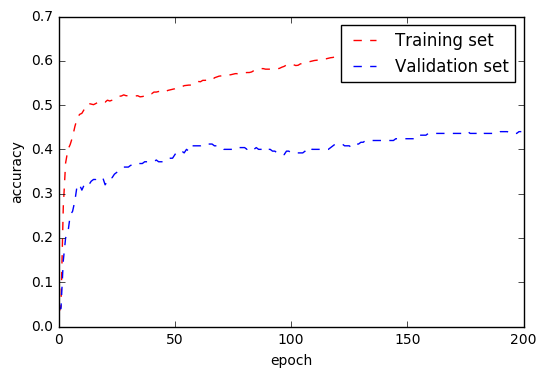

In [138]:
# Stemming & Remove Stopwords
t=list(range(0,NUM_EPOCHS))
plt.plot(t, train_accuracy, 'r--',t,valid_accuracy, 'b--')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Training set", "Validation set","Test set"])
plt.show()

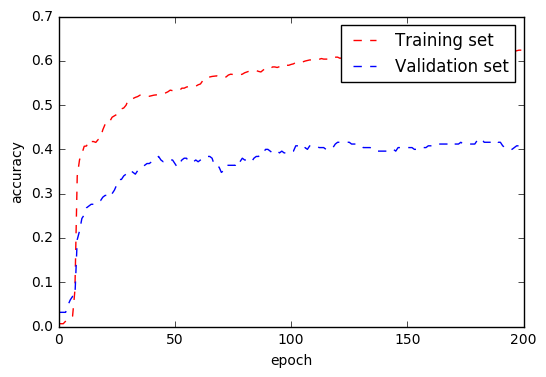

In [129]:
## No Stemming ##
t=list(range(0,NUM_EPOCHS))
plt.plot(t, train_accuracy, 'r--',t,valid_accuracy, 'b--')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Training set", "Validation set","Test set"])
plt.show()

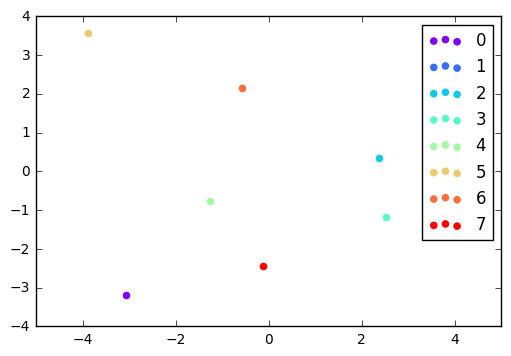

In [90]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm


pca = PCA(n_components=2)
proj = pca.fit_transform(V.transpose())

colors = cm.rainbow(np.linspace(0, 1, len(proj)))
for y, c in zip(proj, colors):
    plt.scatter(y[0], y[1], color=c)
    
plt.legend([0,1,2,3,4,5,6,7])
plt.show()